In [1]:
import sys
import datetime
import plotly
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import sqlalchemy

# import Objectiv Bach
from bach import DataFrame
sys.path.extend([
    '../../bach',
    '../'
])

from objectiv_bach.util import duplo_basic_features

## Get website production data

In [2]:
# connect to full postgresql dataset, add database and credentials here
engine = sqlalchemy.create_engine('postgresql://objectiv:@localhost:5432/objectiv')

In [3]:
# create a buh_tuh dataframe based on the full dataset
basic_features = duplo_basic_features()
full_df = DataFrame.from_model(engine=engine, model=basic_features, index=['event_id'])

## Set the timeframe

In [4]:
# set the timeframe for analysis
timeframe_selector = (full_df['moment'] >= datetime.date(2021,6,1)) & (full_df['moment'] < datetime.date(2021,11,4))

# create one sampled df with timeframe applied 
timeframe_df = full_df[timeframe_selector]

# explore the data
timeframe_df.sort_values(by='moment', ascending=False).head()

,session_id,session_hit_number,user_id,day,moment,cookie_id,value,event_type,global_contexts,location_stack,time,event_types,stack_selection,selected_stack_location,feature_hash,feature,feature_pretty_name
event_id,,,,,,,,,,,,,,,,,
937cd939-396e-455c-9ef0-00f7c22762d2,5289,140,fe2657f1-a08c-4e33-b762-441c2f52855c,2021-11-03,2021-11-03 12:32:39.882,fe2657f1-a08c-4e33-b762-441c2f52855c,"{'id': '937cd939-396e-455c-9ef0-00f7c22762d2',...",CompletedEvent,"[{'id': 'objectiv-website', '_type': 'Applicat...","[{'id': '#document', 'url': 'https://objectiv....",1635942759882,"[AbstractEvent, CompletedEvent, NonInteractive...","(WebDocumentContext,#document),(SectionContext...","[{'id': '#document', '_type': 'WebDocumentCont...",286f0761bf631bdf1fa5ec71f8aaad2b,"(WebDocumentContext,#document),(SectionContext...","Pretty(WebDocumentContext,#document),(SectionC..."
89da87cc-c46f-45a1-8ef5-2578fcf5993d,5289,139,fe2657f1-a08c-4e33-b762-441c2f52855c,2021-11-03,2021-11-03 12:32:38.783,fe2657f1-a08c-4e33-b762-441c2f52855c,"{'id': '89da87cc-c46f-45a1-8ef5-2578fcf5993d',...",ClickEvent,"[{'id': 'objectiv-website', '_type': 'Applicat...","[{'id': '#document', 'url': 'https://objectiv....",1635942758783,"[AbstractEvent, ClickEvent, InteractiveEvent]","(WebDocumentContext,#document),(SectionContext...","[{'id': '#document', '_type': 'WebDocumentCont...",def1e19404eb7c07d69fbac9fcdb4214,"(WebDocumentContext,#document),(SectionContext...","Pretty(WebDocumentContext,#document),(SectionC..."
232fdff8-6a25-4670-afd2-849a350a2359,5289,138,fe2657f1-a08c-4e33-b762-441c2f52855c,2021-11-03,2021-11-03 12:32:38.782,fe2657f1-a08c-4e33-b762-441c2f52855c,"{'id': '232fdff8-6a25-4670-afd2-849a350a2359',...",ClickEvent,"[{'id': 'objectiv-website', '_type': 'Applicat...","[{'id': '#document', 'url': 'https://objectiv....",1635942758782,"[AbstractEvent, ClickEvent, InteractiveEvent]","(WebDocumentContext,#document),(SectionContext...","[{'id': '#document', '_type': 'WebDocumentCont...",def1e19404eb7c07d69fbac9fcdb4214,"(WebDocumentContext,#document),(SectionContext...","Pretty(WebDocumentContext,#document),(SectionC..."
cc9c67bf-b669-4293-96ab-2f98321f4685,5289,137,fe2657f1-a08c-4e33-b762-441c2f52855c,2021-11-03,2021-11-03 12:32:33.069,fe2657f1-a08c-4e33-b762-441c2f52855c,"{'id': 'cc9c67bf-b669-4293-96ab-2f98321f4685',...",SectionVisibleEvent,"[{'id': 'objectiv-website', '_type': 'Applicat...","[{'id': '#document', 'url': 'https://objectiv....",1635942753069,"[AbstractEvent, NonInteractiveEvent, SectionVi...","(WebDocumentContext,#document),(SectionContext...","[{'id': '#document', '_type': 'WebDocumentCont...",0238e851bb1ff57d8e8cd7c5941d3379,"(WebDocumentContext,#document),(SectionContext...","Pretty(WebDocumentContext,#document),(SectionC..."
34f3efb6-6ecd-4510-a10f-d74a6de303bb,5289,136,fe2657f1-a08c-4e33-b762-441c2f52855c,2021-11-03,2021-11-03 12:32:33.067,fe2657f1-a08c-4e33-b762-441c2f52855c,"{'id': '34f3efb6-6ecd-4510-a10f-d74a6de303bb',...",SectionVisibleEvent,"[{'id': 'objectiv-website', '_type': 'Applicat...","[{'id': '#document', 'url': 'https://objectiv....",1635942753067,"[AbstractEvent, NonInteractiveEvent, SectionVi...","(WebDocumentContext,#document),(SectionContext...","[{'id': '#document', '_type': 'WebDocumentCont...",cbb30bbd6e7f7de24cb0c86753af02c3,"(WebDocumentContext,#document),(SectionContext...","Pretty(WebDocumentContext,#document),(SectionC..."


## Set the time aggregation 

In [5]:
# choose for which level of time aggregation the rest of the analysis will run
# supports all Postgres datetime template patterns: https://www.postgresql.org/docs/9.1/functions-formatting.html#FUNCTIONS-FORMATTING-DATETIME-TABLE

agg_level = 'YYYYIW'

# add the time aggregation as new column to the dataframes, so we can group on this later
timeframe_df['time_aggregation'] = timeframe_df['moment'].format(agg_level)
full_df['time_aggregation'] = full_df['moment'].format(agg_level)

## Set the user application

In [6]:
# add a new column to dataframes with the user application from the global contexts
timeframe_df['user_application'] = timeframe_df.global_contexts.json.application
full_df['user_application'] = full_df.global_contexts.json.application

# select one or more user application(s) for analysis, in this case objectiv.io website 
# when selecting more than one application, each of the metrics below can easily be group by user_application to compare behavior
timeframe_df = timeframe_df[(timeframe_df['user_application'] == 'objectiv-website')]
full_df = full_df[(full_df['user_application'] == 'objectiv-website')]

## TEMP filter on IP

In [7]:
# add IP as column and filter on it
timeframe_df['ip'] = timeframe_df.global_contexts.json.get_from_context_with_type_series(type='HttpContext', key='remote_address')
full_df['ip'] = full_df.global_contexts.json.get_from_context_with_type_series(type='HttpContext', key='remote_address')

timeframe_df = timeframe_df[(timeframe_df['ip'] != '144.178.74.106') & 
                            (timeframe_df['ip'] != '77.160.42.36') &
                            (timeframe_df['ip'] != '86.86.89.85')]

full_df = full_df[(full_df['ip'] != '144.178.74.106') & 
                            (full_df['ip'] != '77.160.42.36') &
                            (full_df['ip'] != '86.86.89.85')]

## Users

In [8]:
# calculate unique users per timeframe
users = timeframe_df.groupby('time_aggregation').aggregate({'user_id':'nunique'})

# calculate total users, to reuse later
total_users = timeframe_df['user_id'].nunique()

users.sort_values(by='time_aggregation', ascending=False).head()

,user_id_nunique
time_aggregation,
202144,32
202143,87
202142,91
202141,109
202140,103


<AxesSubplot:xlabel='time_aggregation'>

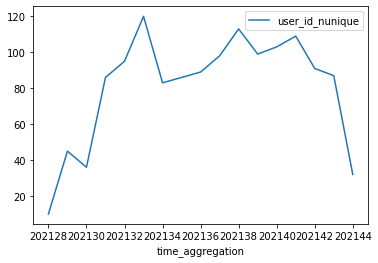

In [9]:
# visualize users
users.sort_values(by='time_aggregation', ascending=True).head(60).plot()

## Sessions

In [10]:
# calculate unique sessions
sessions = timeframe_df.groupby('time_aggregation').aggregate({'session_id':'nunique'})

sessions.sort_values(by='time_aggregation', ascending=False).head()

,session_id_nunique
time_aggregation,
202144,41
202143,104
202142,102
202141,140
202140,127


<AxesSubplot:xlabel='time_aggregation'>

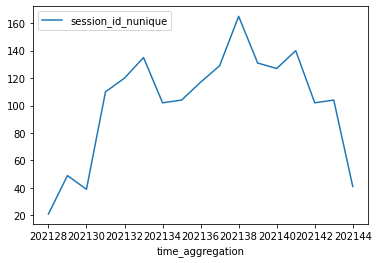

In [11]:
# visualize sessions
sessions.sort_values('time_aggregation', ascending=True).head(60).plot()

## Sessions per user

In [12]:
# merge users and sessions
users_sessions = sessions.merge(users, how='inner', on='time_aggregation')

# calculate average sessions per user
users_sessions['sessions_per_user_avg'] = users_sessions['session_id_nunique'] / users_sessions['user_id_nunique']

# clean-up columns
users_sessions.drop(columns=['session_id_nunique', 'user_id_nunique'], inplace=True)

users_sessions.sort_values('time_aggregation', ascending=False).head()

,sessions_per_user_avg
time_aggregation,
202144,1.281250
202143,1.195402
202142,1.120879
202141,1.284404
202140,1.233010


<AxesSubplot:xlabel='time_aggregation'>

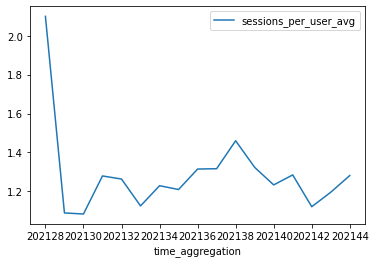

In [13]:
# visualize average sessions per user
users_sessions.sort_values(by='time_aggregation', ascending=True).head(60).plot()

## New users

In [14]:
# define first seen per user, based on full dataset
user_first_seen = full_df.groupby('user_id').aggregate({'time_aggregation':'min', 'session_id':'min'})

# select all users that have been active in the time
active_users = timeframe_df.groupby('user_id').aggregate({'session_id':'nunique'})

# reset index so we can use user_id to join and clean-up columns
active_users = active_users.reset_index()
active_users.drop(columns=['session_id_nunique'], inplace=True)

# merge with users that have been active in the timeframe
user_first_seen = user_first_seen.merge(active_users, how='inner', on='user_id')

# calculate new users for each timeframe
new_users = user_first_seen.groupby('time_aggregation_min').aggregate({'user_id':'nunique'})

# merge with total users to calculate ratio and limit to timerange
new_total_users = users.merge(new_users, how='inner', left_on='time_aggregation', right_on='time_aggregation_min', suffixes=('_total', '_new'))

# set time_aggregation as single index
new_total_users = new_total_users.set_index('time_aggregation')

# calculate new & returning user share
new_total_users['new_user_share'] = new_total_users['user_id_nunique_new'] / new_total_users['user_id_nunique_total']
new_total_users['returning_user_share'] = (new_total_users['user_id_nunique_total'] - new_total_users['user_id_nunique_new']) / new_total_users['user_id_nunique_total']

new_total_users.sort_values(by='time_aggregation', ascending=False).head()

,user_id_nunique_total,user_id_nunique_new,new_user_share,returning_user_share
time_aggregation,,,,
202144,32,27,0.843750,0.156250
202143,87,76,0.873563,0.126437
202142,91,82,0.901099,0.098901
202141,109,94,0.862385,0.137615
202140,103,92,0.893204,0.106796


<AxesSubplot:xlabel='time_aggregation'>

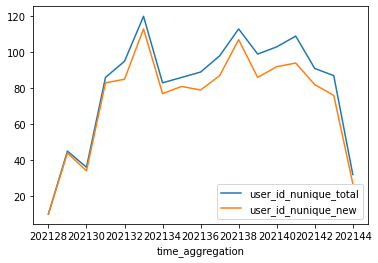

In [15]:
# visualize new users
new_total_users[['user_id_nunique_new', 'user_id_nunique_total']].sort_values(by='time_aggregation', ascending=True).head(60).plot()

<AxesSubplot:xlabel='time_aggregation'>

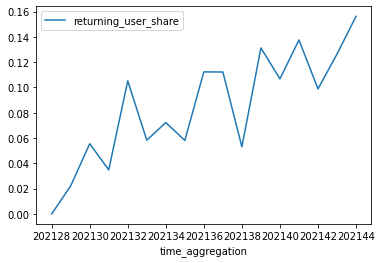

In [16]:
# visualize returning users
new_total_users[['returning_user_share']].sort_values(by='time_aggregation', ascending=True).head(60).plot()

## Events

In [17]:
# add the event location from the location_stack as new column to the df
timeframe_df['event_location'] = timeframe_df.location_stack.json.nice_name

# get the number of total users and hits per feature
users_per_event = timeframe_df.groupby(['time_aggregation', 'event_type', 'event_location']).aggregate({'user_id':'nunique','session_hit_number':'count'})

users_per_event.sort_values(by=['time_aggregation', 'user_id_nunique'], ascending=False).head()

session_hit_number_count  \
time_aggregation event_type             event_location                                                                 
202144           ApplicationLoadedEvent Web Document: #document                                                   39   
                 SectionHiddenEvent     Section: header located at Web Document: #document                        30   
                 SectionVisibleEvent    Section: footer located at Web Document: #document                        28   
                 SectionHiddenEvent     Section: navbar-top located at Web Document: #d...                        29   
                                        Section: footer located at Web Document: #document                        28   

                                                                                            user_id_nunique  
time_aggregation event_type             event_location                                                       
202144           ApplicationLoadedEvent Web Document: #document                                          30  
                 SectionHiddenEvent     Section: header located at Web Document: #document               11  
                 SectionVisibleEvent    Section: footer located at Web Document: #document               11  
                 SectionHiddenEvent     Section: navbar-top located at Web Document: #d...               10  
                                        Section: footer located at Web Document: #document               10

## New user events

In [18]:
# look at the first 10 things new users do

# get the first session for users that were new in the timeframe
timeframe_new_users = timeframe_df.merge(user_first_seen, how='inner', left_on=['user_id', 'time_aggregation', 'session_id'], right_on=['user_id', 'time_aggregation_min', 'session_id_min'])

# limit to the first 10 events
timeframe_new_users = timeframe_new_users[(timeframe_new_users['session_hit_number'] <= 10)]

# number of total user and hits per feature
new_user_events = timeframe_new_users.groupby(['time_aggregation', 'event_type', 'event_location']).aggregate({'user_id':'nunique','session_hit_number':'count'})

new_user_events.sort_values(by=['time_aggregation', 'user_id_nunique'], ascending=False).head()

session_hit_number_count  \
time_aggregation event_type             event_location                                                                 
202144           ApplicationLoadedEvent Web Document: #document                                                   27   
                 SectionHiddenEvent     Section: header located at Web Document: #document                         6   
                                        Section: announcement-bar located at Web Docume...                         5   
                                        Section: footer located at Web Document: #document                         5   
                                        Section: keep-me-posted-form located at Web Doc...                         5   

                                                                                            user_id_nunique  
time_aggregation event_type             event_location                                                       
202144           ApplicationLoadedEvent Web Document: #document                                          25  
                 SectionHiddenEvent     Section: header located at Web Document: #document                6  
                                        Section: announcement-bar located at Web Docume...                5  
                                        Section: footer located at Web Document: #document                5  
                                        Section: keep-me-posted-form located at Web Doc...                5

## WIP Conversion

In [19]:
# NOTE - find conversion feature - replace with sankey when we have it?

# filter on only completed conversion events, in the case a successful submission of keep-me-posted form
conversion_completed = timeframe_df[(timeframe_df['event_type'] == 'CompletedEvent') &
                                    (timeframe_df['event_location'] == 'Section: keep-me-posted-form located at Web Document: #document => Section: header')]

# calculate conversions, now per user, but can easily be aggregated to session_id instead
conversions = conversion_completed.groupby('time_aggregation').aggregate({'user_id':'nunique'})

# merge with users, but can easily be done with sessions instead
conversion_rate = conversions.merge(users, how='inner', on='time_aggregation', suffixes=('_converting', '_total'))

# calculate conversion rate
conversion_rate['conversion_rate'] = conversion_rate['user_id_nunique_converting'] / conversion_rate['user_id_nunique_total']

conversion_rate.sort_values(by='time_aggregation', ascending=False).head()

,user_id_nunique_converting,user_id_nunique_total,conversion_rate
time_aggregation,,,
202144,1,32,0.03125


<AxesSubplot:xlabel='time_aggregation'>

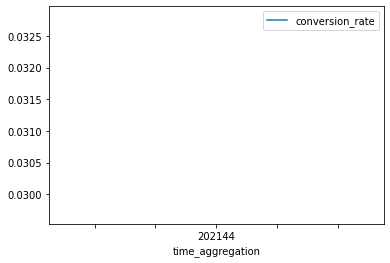

In [20]:
# visualize conversion rate
conversion_rate[['conversion_rate']].sort_values(by='time_aggregation', ascending=True).head(60).plot()

## WIP Conversion error rate

In [21]:
# NOTE replace with sankey when we have it?

# filter on only conversion start events, this case a click on 'keep me posted' button
conversion_start = timeframe_df[(timeframe_df['event_type'] == 'ClickEvent') &
                               (timeframe_df['event_location'] == 'Button: subscribe located at Web Document: #document => Section: header => Section: keep-me-posted-form')]

# calculate conversion starts, now per user, but can easily be aggregated to session_id instead
conversion_starts = conversion_start.groupby('time_aggregation').aggregate({'user_id':'nunique'})

# join conversion start & complete events
conversion_totals = conversion_starts.merge(conversions, how='inner', on='time_aggregation')

# rename columns
conversion_totals.rename(columns={'user_id_nunique_x':'users_start','user_id_nunique_y':'users_completed'}, inplace=True)

# calculate error rate by comparing starting and successfully completing a conversion event
conversion_totals['error_rate'] = (conversion_totals['users_start'] - conversion_totals['users_completed']) / conversion_totals['users_start']

conversion_totals.sort_values(by='time_aggregation', ascending=False).head()

,users_start,users_completed,error_rate
time_aggregation,,,
202144,1,1,0.0


## WIP Conversion funnel

In [22]:
# for users that have a conversion event, select their conversion sessions and session_hit_number of the conversion moment
converting_users = conversion_completed.groupby(['user_id', 'session_id']).aggregate({'session_hit_number':'max'})

# merge with the df that has all user events in the timeframe
converting_users_events = timeframe_df.merge(converting_users, how='inner', on=['user_id', 'session_id'])

# select all events that converting users had up to their conversion moment in the same session
converting_users_events = converting_users_events[(converting_users_events['session_hit_number'] <= converting_users_events['session_hit_number_max'])]

# filter on only ClickEvent so we focus on user interactions
converting_users_events = converting_users_events[(converting_users_events['event_type'] == 'ClickEvent')]

# select all unique features used by these users
converting_users_features = converting_users_events.groupby(['event_location']).aggregate({'event_id':'nunique'})

# sort these features by name
converting_users_features = converting_users_features.sort_values(by='event_location', ascending=True)

# now we switch to Pandas, as the dataset is small enough and allows nice visualisation
feature_id = converting_users_features.to_df().reset_index()

# clean-up columns
feature_id.drop(columns=['event_id_nunique'], inplace=True)

# use the index to give each feature a unique id
feature_id['feature_id'] = feature_id.index

# create a window that returns the previous event for each row
window = converting_users_events.sort_values('session_hit_number').window('session_id')
converting_users_events['prev_event_location'] = converting_users_events.event_location.window_lag(window)

# materizalize the df before we apply an expression on window
converting_users_events = converting_users_events.get_df_materialized_model()

# group each unique event by previous unique event
from_to_events = converting_users_events.groupby(['prev_event_location', 'event_location']).aggregate({'event_id':'nunique'})

# now we switch to Pandas, as the dataset is small enough and allows nice visualisation
from_to_events_pd = from_to_events.to_df().reset_index()

# merge with the unique id for each prev_feature
sankey_input = from_to_events_pd.merge(feature_id, how='inner', left_on='prev_event_location', right_on='event_location')
sankey_input = sankey_input.rename(columns={'event_location_x':'event_location', 'feature_id':'prev_feature_id'})
sankey_input = sankey_input.drop(columns={'event_location_y'})

# merge with the unique id for each feature
sankey_input = sankey_input.merge(feature_id, how='left', left_on='event_location', right_on='event_location')

# filter out events where prev_feature and feature are the same and user did not go anywhere new
sankey_input = sankey_input[(sankey_input['prev_feature_id'] != sankey_input['feature_id'])]

# sort by feature, so we can add the correct labels in the sankey
sankey_input = sankey_input.sort_values(by=['feature_id', 'prev_feature_id'], ascending=True)
sankey_input.head()

,prev_event_location,event_location,event_id_nunique,prev_feature_id,feature_id
3,Link: logo located at Web Document: #document ...,Button: subscribe located at Web Document: #do...,2,3,0
7,Link: Twitter located at Web Document: #docume...,Link: Contact Us located at Web Document: #doc...,1,6,2
1,Link: announcement-cta located at Web Document...,Link: logo located at Web Document: #document ...,1,1,3
2,Link: Contact Us located at Web Document: #doc...,Link: logo located at Web Document: #document ...,1,2,3
5,Link: Privacy Policy located at Web Document: ...,Link: logo located at Web Document: #document ...,1,4,3


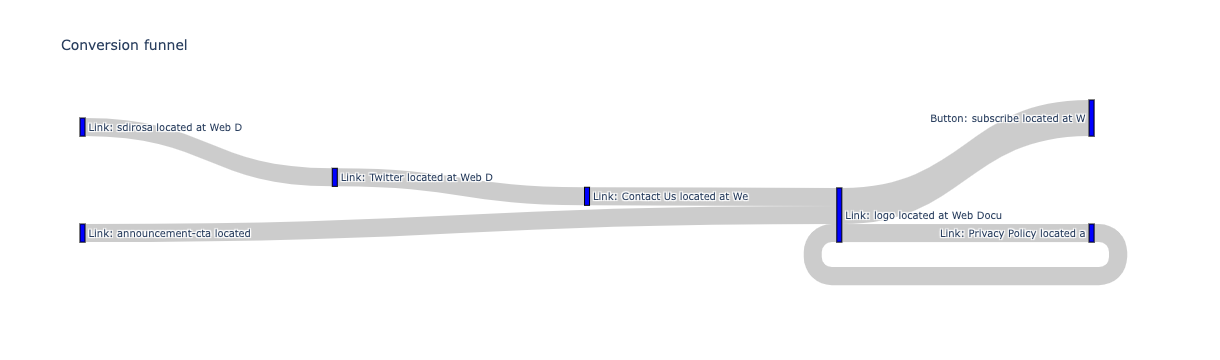

In [58]:
# visualize the sankey
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 50,
      thickness = 5,
      line = dict(color = "black", width = 1),
      label = feature_id['event_location'].str.slice(0,30).tolist(),
      color = "blue"
    ),
    link = dict(
      source = sankey_input['prev_feature_id'].tolist(),
      target = sankey_input['feature_id'].tolist(),
      value = sankey_input['event_id_nunique'].tolist(),
  ))])

fig.update_layout(title_text="Conversion funnel", font_size=10)
fig.show()

## Session duration

In [24]:
# calculate duration of each session
session_duration = timeframe_df.groupby(['session_id']).aggregate({'moment':['min','max'], 'time_aggregation':'min'})
session_duration['session_duration'] = session_duration['moment_max'] - session_duration['moment_min']

# check which sessions have duration of zero and filter these out, as they are bounces
session_duration = session_duration[(session_duration['session_duration'] > '0')]

# rename columns
session_duration.rename(columns={'time_aggregation_min':'time_aggregation'}, inplace=True)

# calculate average session duration
avg_session_duration = session_duration.groupby(['time_aggregation']).aggregate({'session_duration': 'mean'})

avg_session_duration.sort_values(by='time_aggregation', ascending=False).head()

,session_duration_mean
time_aggregation,
202144,0 days 00:00:19.126647
202143,0 days 00:00:32.229353
202142,0 days 00:00:23.995933
202141,0 days 00:00:42.266514
202140,0 days 00:00:42.188256


## WIP Session duration between events


In [25]:
# NOTE: replace event selection with sankey

# NOTE: stop event is old, replace with something better (after we add feature selection)

# define the start and stop events to measure the duration in between, in this case landing on homepage and completing conversion
start_event = '(WebDocumentContext,#document)'
stop_event = '(WebDocumentContext,#document),(SectionContext,keep-me-posted-form),(ActionContext,keep-me-posted)'

# filter on only these events
start_stop = timeframe_df[(timeframe_df.feature == start_event) | (timeframe_df.feature == stop_event)]

# get previous (because of the sorting) event for stop event _in the same session, window_lag(n) returns the nth previous value in the partition
window = start_stop.sort_values('moment').window('session_id')
start_stop['prev_event'] = start_stop.feature.window_lag(window)
start_stop['prev_moment'] = start_stop.moment.window_lag(window)

# materizalize the df before we apply an expression on window
start_stop = start_stop.get_df_materialized_model()

# filter: for each stop event, select the closest preceeding start event
complete = start_stop[(start_stop.feature == stop_event) & (start_stop.prev_event == start_event)]

# calculate duration
complete['duration'] = complete.moment - complete.prev_moment

# calculate average duration per timeframe
duration_between_events = complete.groupby('time_aggregation').aggregate({'duration':'mean'})

duration_between_events.sort_values(by='time_aggregation', ascending=False).head()

,duration_mean
time_aggregation,
202143,0 days 00:00:07.535000
202142,0 days 00:00:06.521500
202141,0 days 00:00:07.131000
202140,0 days 00:00:09.851000


## Retention

In [26]:
# select all active moments for each user
user_moments = timeframe_df.groupby(['user_id', 'time_aggregation']).aggregate({'moment':'count'})

# merge with first seen df
user_activity = user_moments.merge(user_first_seen, how='inner', on='user_id')

# clean-up and rename columns
user_activity.rename(columns={'time_aggregation_min':'new_user_cohort'}, inplace=True)
user_activity.drop(columns=['moment_count'], inplace=True)

# limit new users to the selected timeframe
timeframe_start = timeframe_df['time_aggregation'].min()
user_activity = user_activity[(user_activity['new_user_cohort'] >= timeframe_start[1])]

# for each new_user_cohort count how many users get back per timeframe
retention_input = user_activity.groupby(['new_user_cohort', 'time_aggregation']).aggregate({'user_id':'nunique'})

# add the size of each new user cohort
cohorts = retention_input.merge(new_users, how='inner', left_on='new_user_cohort', right_on='time_aggregation_min', suffixes=('_active', '_cohort'))

# calculate classic retention (so not rolling retention, where users are required to be active each timeframe)
cohorts['retention'] = cohorts['user_id_nunique_active'] / cohorts['user_id_nunique_cohort']

# now we switch to Pandas, as the dataset is small enough and allows nice visualisation
cohorts_pd = cohorts.to_df().reset_index()

# create typical retention matrix
# NOTE this needs a proper solution for daily data, then the int type does not work to calculate diff. @Hendrik if you know of one, love to hear. Tried cast as datetime64, but that makes a mess out of the cohort visual, as it does not show cohort numbers anymore.
cohorts_pd = cohorts_pd.astype({'new_user_cohort': 'int', 'time_aggregation': 'int'})
cohorts_pd['active_in_timeframe'] = cohorts_pd.time_aggregation - cohorts_pd.new_user_cohort
cohorts_pd.pivot('new_user_cohort', 'active_in_timeframe', 'retention').replace(np.nan, 0)

active_in_timeframe,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
new_user_cohort,,,,,,,,,,,,,,,,,
202128,1.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.200000,0.000000,0.200000,0.100000,0.000000,0.100000,0.100000,0.100000,0.100000,0.1,0.1
202129,1.0,0.022727,0.045455,0.090909,0.045455,0.045455,0.045455,0.045455,0.022727,0.000000,0.045455,0.045455,0.045455,0.045455,0.045455,0.0,0.0
202130,1.0,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
202131,1.0,0.048193,0.024096,0.024096,0.000000,0.024096,0.036145,0.024096,0.024096,0.012048,0.036145,0.000000,0.012048,0.012048,0.000000,0.0,0.0
202132,1.0,0.023529,0.000000,0.000000,0.011765,0.000000,0.000000,0.011765,0.000000,0.000000,0.011765,0.011765,0.000000,0.000000,0.000000,0.0,0.0
202133,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
202134,1.0,0.038961,0.012987,0.025974,0.012987,0.025974,0.012987,0.012987,0.012987,0.012987,0.012987,0.000000,0.000000,0.000000,0.000000,0.0,0.0
202135,1.0,0.024691,0.024691,0.012346,0.012346,0.012346,0.024691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
202136,1.0,0.025316,0.000000,0.000000,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


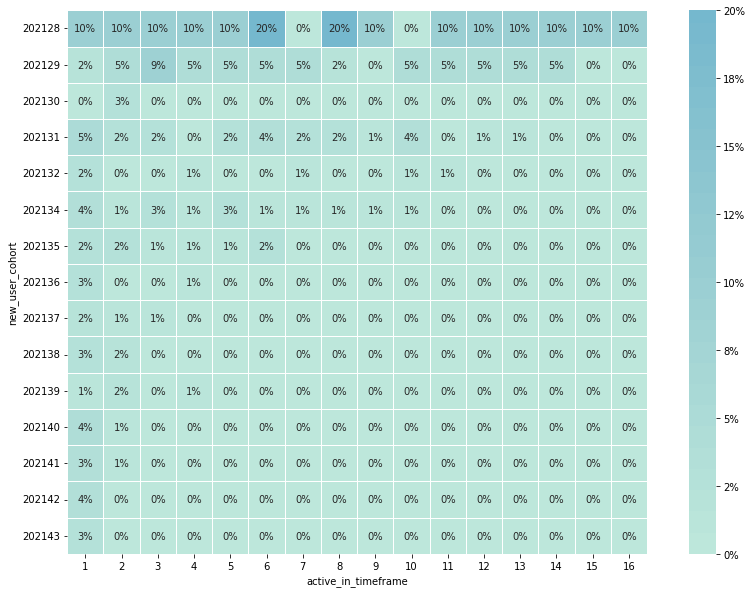

In [27]:
# NOTE: this does not look well yet for daily data instead of weekly. @hendrik let's discuss as part of review.
# remove timeframe 0 where the new users are all there, for better visualisation
cohorts_pd.drop(cohorts_pd[cohorts_pd.active_in_timeframe == 0].index, inplace=True)

# create retention matrix
retention_pd = cohorts_pd.pivot('new_user_cohort', 'active_in_timeframe', 'retention').replace(np.nan, 0)

# visualize heatmap
plt.figure(figsize=(15,10))
fmt = lambda x,pos: '{:.0%}'.format(x)
retention_heatmap = sns.heatmap(retention_pd, center=1, linewidths=1, square=True, annot=True, fmt=".0%", cbar_kws={'format': FuncFormatter(fmt)})

## Bounce rate

In [28]:
# gather sessions, hits per timeframe
hits_sessions = timeframe_df[['time_aggregation', 'session_id', 'session_hit_number']]

# calculate hits per session
hits_per_session = hits_sessions.groupby(['time_aggregation', 'session_id']).aggregate({'session_hit_number':'nunique'})

# select sessions with only one hit
hit_selector = (hits_per_session['session_hit_number_nunique'] == 1)
single_hit_sessions = hits_per_session[hit_selector].to_frame()

# count these single hit sessions per timeframe
bounced_sessions = single_hit_sessions.groupby('time_aggregation').aggregate({'session_id':'nunique'})

# merge with total sessions
bounce_rate = bounced_sessions.merge(sessions, how='inner', on='time_aggregation', suffixes=('_bounce', '_total'))

# calculate bounce rate
bounce_rate['bounce_rate'] = bounce_rate['session_id_nunique_bounce'] / bounce_rate['session_id_nunique_total']

# clean-up columns
bounce_rate.drop(columns=['session_id_nunique_bounce', 'session_id_nunique_total'], inplace=True)

bounce_rate.sort_values(by='time_aggregation', ascending=False).head()

,bounce_rate
time_aggregation,
202144,0.585366
202143,0.673077
202142,0.705882
202141,0.750000
202140,0.661417


<AxesSubplot:xlabel='time_aggregation'>

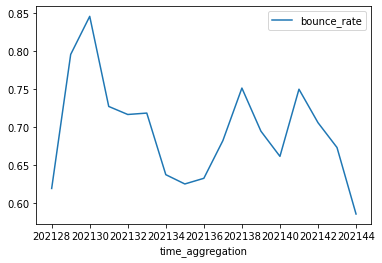

In [29]:
# visualize bounce rate
bounce_rate[['bounce_rate']].sort_values(by='time_aggregation', ascending=True).head(60).plot()

## User agent

In [30]:
# add a new column to df with the user_agent from the global contexts
timeframe_df['user_agent'] = timeframe_df.global_contexts.json.user_agent

# gather overall basic stats grouped per user_agent
user_agent_counts = timeframe_df.groupby(['time_aggregation', 'user_agent']).aggregate({'user_id':'nunique', 'session_id':'nunique'})

# add total users and calculate share per user_agent
user_agent_counts['total_users'] = total_users[1]

# calculate share per user_agent
user_agent_counts['share_of_users'] = user_agent_counts['user_id_nunique'] / user_agent_counts['total_users']

# clean-up colums
user_agent_counts.drop(columns=['total_users'], inplace=True)

user_agent_counts.sort_values(by=['time_aggregation', 'user_id_nunique'], ascending=False).head()

session_id_nunique  \
time_aggregation user_agent                                                               
202144           Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)...                  12   
                 Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKi...                   6   
                 Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537...                   4   
                 Mozilla/5.0 (Macintosh; Intel Mac OS X 11_2_3) ...                   3   
                 Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...                   3   

                                                                     user_id_nunique  \
time_aggregation user_agent                                                            
202144           Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)...                6   
                 Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKi...                6   
                 Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537...                4   
                 Mozilla/5.0 (Macintosh; Intel Mac OS X 11_2_3) ...                3   
                 Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...                3   

                                                                     share_of_users  
time_aggregation user_agent                                                          
202144           Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)...        0.004773  
                 Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKi...        0.004773  
                 Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537...        0.003182  
                 Mozilla/5.0 (Macintosh; Intel Mac OS X 11_2_3) ...        0.002387  
                 Mozilla/5.0 (Windows NT 10.0; Win64; x64) Apple...        0.002387

## Referer

In [31]:
# add a new column to dataframe with the referer from the global contexts
timeframe_df['referer'] = timeframe_df.global_contexts.json.get_from_context_with_type_series(type='HttpContext', key='referer')

# gather overall basic stats grouped per referer
referer_counts = timeframe_df.groupby(['time_aggregation', 'referer']).aggregate({'user_id':'nunique', 'session_id':'nunique'})

# add total users and calculate share per referer
referer_counts['total_users'] = total_users[1]

# calculate share per referer
referer_counts['share_of_users'] = referer_counts['user_id_nunique'] / referer_counts['total_users']

# clean-up colums
referer_counts.drop(columns=['total_users'], inplace=True)

referer_counts.sort_values(by=['time_aggregation', 'user_id_nunique'], ascending=False).head()

session_id_nunique  \
time_aggregation referer                                        
202144           https://objectiv.io/                      35   
                 https://www.objectiv.io/                   6   
202143           https://objectiv.io/                      96   
                 https://www.objectiv.io/                  11   
                 https://objectiv.io/jobs                   2   

                                           user_id_nunique  share_of_users  
time_aggregation referer                                                    
202144           https://objectiv.io/                   27        0.021480  
                 https://www.objectiv.io/                5        0.003978  
202143           https://objectiv.io/                   81        0.064439  
                 https://www.objectiv.io/               11        0.008751  
                 https://objectiv.io/jobs                2        0.001591

## User timeline

In [32]:
# show the timeline of an indivual user's events
# NOTE: we can make this better with feature selection & aggregation

# select the spefic user we want to replay
# NOTE: .astype('string') is more something buhtuh should handle, on list
user_selector = (timeframe_df['user_id'].astype('string') == '320db8ee-847c-424b-8291-c65d021575aa')

# create df with only this user's events
selected_user_df = timeframe_df[user_selector]

# NOTE: we can apply feature selection and maybe sankey visual here
# timeline of this user's events
user_timeline = selected_user_df[['moment','event_type', 'event_location', 'user_agent', 'referer']]

user_timeline.sort_values(by='moment', ascending=True).head()

,moment,event_type,event_location,user_agent,referer
event_id,,,,,


## Frequency

In [33]:
# number of total sessions per user
total_sessions_user = timeframe_df.groupby(['user_id']).aggregate({'session_id':'nunique'})

# calculate frequency
frequency = total_sessions_user.groupby(['session_id_nunique']).aggregate({'user_id':'nunique'})

# add total users and calculate share per number of sessions
frequency['share_of_users'] = frequency['user_id_nunique'] / total_users[1]

frequency.sort_values(by='session_id_nunique', ascending=True).head()

,user_id_nunique,share_of_users
session_id_nunique,,
1,1104,0.878282
2,102,0.081146
3,21,0.016706
4,11,0.008751
5,4,0.003182


<AxesSubplot:xlabel='session_id_nunique'>

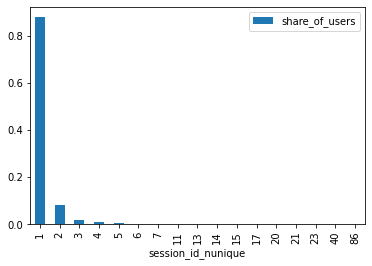

In [34]:
# visualize frequency
frequency[['share_of_users']].sort_values(by='session_id_nunique', ascending=True).head(60).plot(kind='bar')

## Recency

In [35]:
# count the number of active days per user
user_active_check = timeframe_df.groupby(['user_id']).aggregate({'day':'nunique'})

# select all users that had more than one active day
user_active_check = user_active_check[(user_active_check['day_nunique'] > 1)]

# select all active days for each user
user_days = timeframe_df.groupby(['user_id', 'day']).aggregate({'time_aggregation':'min'})

# merge with users that have more than one active day
user_days = user_days.merge(user_active_check, how='inner', on='user_id')

# reset the index so we can use the user_id & day columns
user_days = user_days.reset_index()

# get previous (because of the sorting) day for each user
window = user_days.sort_values('day').window(['user_id'])
user_days['prev_day'] = user_days.day.window_lag(window)

# materizalize the df before we apply an expression on window
user_days = user_days.get_df_materialized_model()

# calculate the number of days between an active day and prev_day
user_days['recency'] = user_days['day'] - user_days['prev_day']

# rename columns
user_days.rename(columns={'time_aggregation_min':'time_aggregation'}, inplace=True)

# calculate the recency per time_aggregation
recency = user_days.groupby(['time_aggregation']).aggregate({'recency':'mean','user_id':'nunique'})

recency.sort_values(by='time_aggregation', ascending=False).head()

,user_id_nunique,recency_mean
time_aggregation,,
202144,5,7.500000
202143,14,5.944444
202142,12,6.571429
202141,19,7.230769
202140,20,6.909091


<AxesSubplot:xlabel='time_aggregation'>

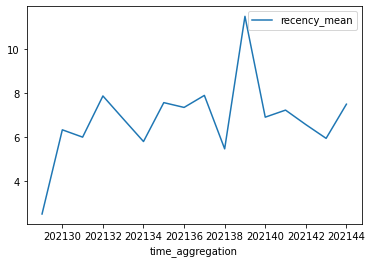

In [36]:
# visualize recency
recency[['recency_mean']].sort_values(by='time_aggregation', ascending=True).head(60).plot()

## Get metrics to production

In [37]:
# We're working on export functionality to dbt, until then, you can use view_sql() to get the SQL that runs on the full dataset for any metric above

# As an example, the SQL for the session duration metric
print(avg_session_duration.view_sql())

with ExtractedContexts___b2a80076da9ff7590b6632157368c76c as (
SELECT *,
        value->>'_type' AS event_type,
        JSON_EXTRACT_PATH(value, 'global_contexts') AS global_contexts,
        JSON_EXTRACT_PATH(value, 'location_stack') AS location_stack,
        JSON_EXTRACT_PATH(value, 'time') AS time,
        JSON_EXTRACT_PATH(value, '_types') AS event_types
 FROM data
 ),
selected_stacks_0daec28eae360a61142b2852b2d86d7c as (
SELECT   event_id,
         Array_to_string(Array_agg(Cast(x AS TEXT)),',') AS stack_selection,
         Array_to_json(Array_agg(Row_to_json(x))) as selected_stack_location
FROM     ExtractedContexts___b2a80076da9ff7590b6632157368c76c,
         json_to_recordset(location_stack) AS x(_type text,id text)
GROUP BY event_id
ORDER BY event_id
),
HashedFeatures___0daec28eae360a61142b2852b2d86d7c as (SELECT *,
       md5(concat(stack_selection,event_type)) as feature_hash
FROM ExtractedContexts___b2a80076da9ff7590b6632157368c76c
JOIN selected_stacks_0daec28eae360a61142b